In [1]:
# !unzip store-sales-time-series-forecasting.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split

In [3]:
pd.set_option('float_format', '{:f}'.format)

##train.csv
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

##test.csv
The test data, having the same features as the training data. You will predict  the target sales for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.

##sample_submission.csv
A sample submission file in the correct format.

##stores.csv
Store metadata, including city, state, type, and cluster.
* **cluster** is a grouping of similar stores.

##oil.csv
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

##holidays_events.csv
Holidays and Events, with metadata


NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type yhk Day which is a day not normally scheduled for yhk (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

# Several questions to data:
* Trends of sales
    * by all time
    * day-by-day changes throughout week
    * week-by-week changes throughout month
    * monthly changes throughout each year
    
* How does oil prices affect sales if so?
* How differ nb stores?

In [4]:
import glob
import pandas as pd

dfs = dict()

for df_name in glob.glob('*.csv'):
    print(df_name)
    
    try:
        dfs[df_name.split('.')[0]] = pd.read_csv(df_name, parse_dates=['date'])
    except Exception as err:
        print(err)
        dfs[df_name.split('.')[0]] = pd.read_csv(df_name)

    print()

df_train = dfs['train']


submission.csv
Missing column provided to 'parse_dates': 'date'

test.csv

oil.csv

transactions.csv

sample_submission.csv
Missing column provided to 'parse_dates': 'date'

train.csv

holidays_events.csv

stores.csv
Missing column provided to 'parse_dates': 'date'



<AxesSubplot:>

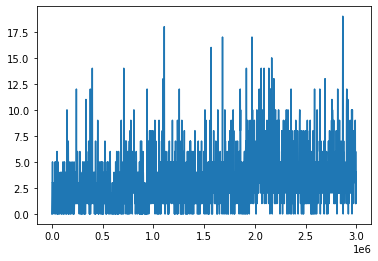

In [5]:
df_train[(df_train['store_nbr'] == 1) & (df_train['family'] == 'AUTOMOTIVE')]['sales'].plot()

<AxesSubplot:>

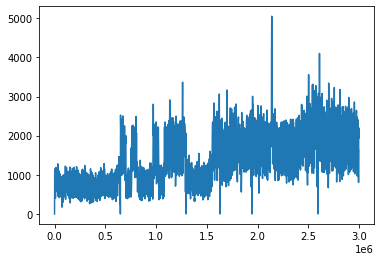

In [6]:
df_train[(df_train['store_nbr'] == 1) & (df_train['family'] == 'BEVERAGES')]['sales'].plot()

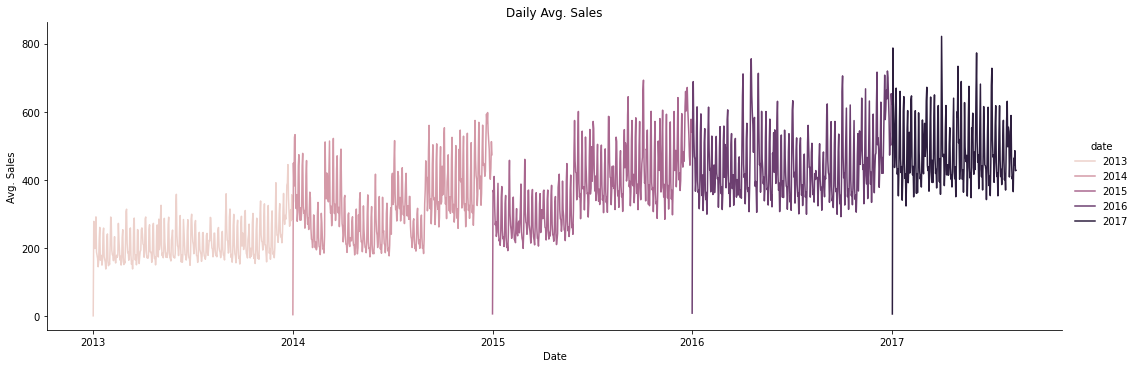

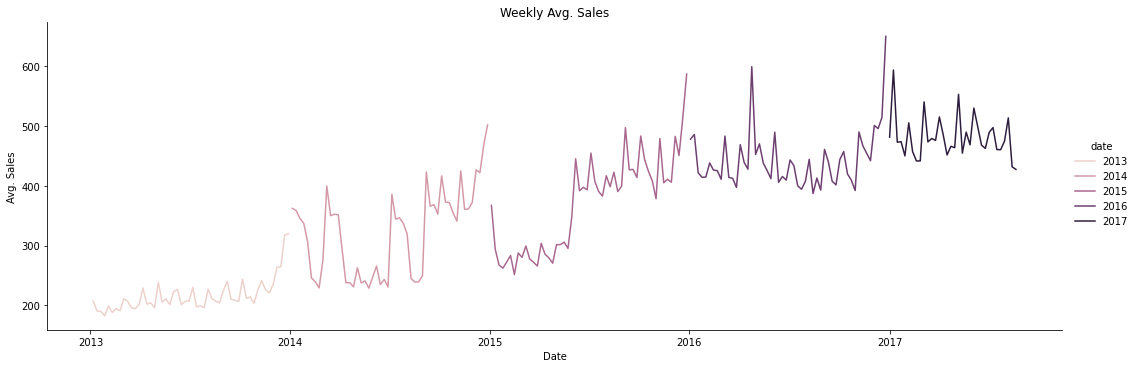

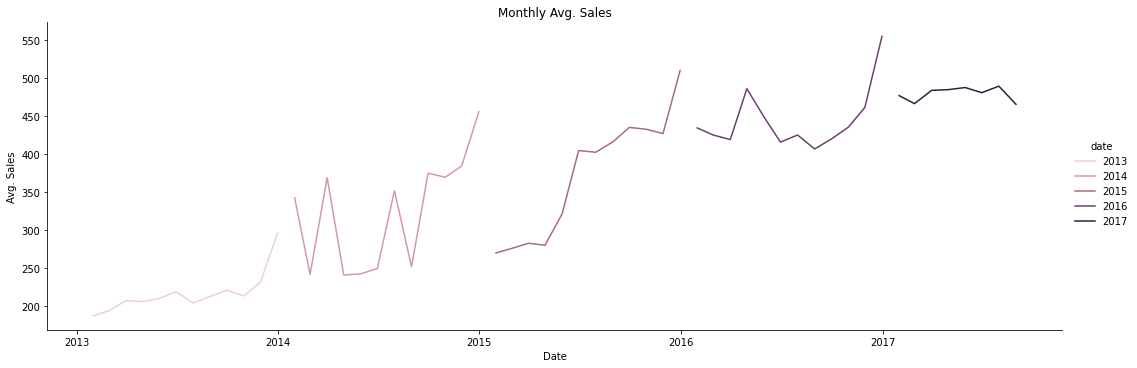

In [7]:
df_train_date = df_train.set_index('date')

daily_sales   = df_train_date.resample('D').sales.mean().to_frame()  ## Resample sales by day
weekly_sales  = df_train_date.resample('W').sales.mean().to_frame()  ## Resample sales by week
monthly_sales = df_train_date.resample('M').sales.mean().to_frame()  ## Resample sales by month

df = [daily_sales,weekly_sales,monthly_sales]
titles = ['Daily Avg. Sales','Weekly Avg. Sales','Monthly Avg. Sales']

for i, j in zip(df,titles):
    
    sns.relplot(x=i.index,y=i.sales,kind='line',aspect=3,hue=i.index.year)
    plt.xlabel('Date')
    plt.ylabel('Avg. Sales')
    plt.title(j)

plt.show()

<AxesSubplot:xlabel='family'>

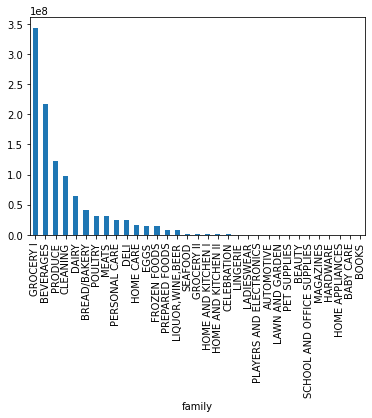

In [8]:
df_train.groupby(['family']).sales.sum().sort_values(ascending=False).plot(kind='bar', )

<AxesSubplot:xlabel='family'>

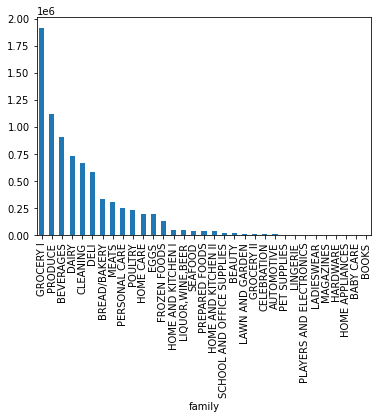

In [9]:
df_train.groupby(['family']).onpromotion.sum().sort_values(ascending=False).plot(kind='bar')

In [10]:
dfs['train'].family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

# Feature generation

In [11]:
initial_train_size = dfs['train'].count()

df_full = pd.concat([dfs['train'], dfs['test']])
df_full

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


## Dates:

In [12]:
df_full['weekday'] = df_full.date.dt.weekday
df_full['year'] = df_full.date.dt.year
df_full['month'] = df_full.date.dt.month
df_full['day_of_year'] = df_full.date.dt.day + (df_full['month'] * 30) #df_full.apply(lambda x : (x.date - datetime.datetime(x.date.year, 1, 1)).days + 1, axis=1)

In [13]:
df_full['global_start'] = datetime.datetime(df_full.iloc[0].date.year, 1, 1)
df_full['day_from_global_start'] = (df_full.date - df_full.global_start).dt.days
df_full = df_full.drop('global_start', axis=1)

In [14]:
df_full

,id,date,store_nbr,family,sales,onpromotion,weekday,year,month,day_of_year,day_from_global_start
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,1,2013,1,31,0
1,1,2013-01-01,1,BABY CARE,0.000000,0,1,2013,1,31,0
2,2,2013-01-01,1,BEAUTY,0.000000,0,1,2013,1,31,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0,1,2013,1,31,0
4,4,2013-01-01,1,BOOKS,0.000000,0,1,2013,1,31,0
...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1,3,2017,8,271,1703
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,3,2017,8,271,1703
28509,3029397,2017-08-31,9,PRODUCE,NaN,1,3,2017,8,271,1703
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,3,2017,8,271,1703


## Oil features

In [15]:
# dfs['oil'] = pd.read_csv('oil.csv', parse_dates=['date'])

In [16]:
dfs['oil'] = dfs['oil'].fillna(method='bfill')

In [17]:
# df_full = df_full.drop('dcoilwtico_y', axis=1)
df_full = pd.merge(df_full, dfs['oil'], on='date', how='left')

In [18]:
df_full

,id,date,store_nbr,family,sales,onpromotion,weekday,year,month,day_of_year,day_from_global_start,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,1,2013,1,31,0,93.140000
1,1,2013-01-01,1,BABY CARE,0.000000,0,1,2013,1,31,0,93.140000
2,2,2013-01-01,1,BEAUTY,0.000000,0,1,2013,1,31,0,93.140000
3,3,2013-01-01,1,BEVERAGES,0.000000,0,1,2013,1,31,0,93.140000
4,4,2013-01-01,1,BOOKS,0.000000,0,1,2013,1,31,0,93.140000
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,3,2017,8,271,1703,47.260000
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,3,2017,8,271,1703,47.260000
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,3,2017,8,271,1703,47.260000
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,3,2017,8,271,1703,47.260000


## Holidays

In [19]:
dfs['holidays_events'] = dfs['holidays_events'].drop_duplicates(subset='date')

In [20]:
df_full = pd.merge(df_full, dfs['holidays_events'][['date', 'type']], on='date', how='left')

In [21]:
df_full['type'].value_counts(dropna=False)

NaN           2578554
Holiday        272646
Event           87318
Additional      64152
Transfer        14256
Work Day         7128
Bridge           5346
Name: type, dtype: int64

In [22]:
df_full['is_holiday'] = (~df_full['type'].isna()).astype(int)

In [23]:
df_full['is_holiday'].value_counts()

0    2578554
1     450846
Name: is_holiday, dtype: int64

## Cities and states

In [24]:
dfs['stores'].head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [25]:
dfs['stores'].cluster.value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

In [26]:
df_full = pd.merge(df_full, dfs['stores'][['store_nbr', 'city', 'state', 'cluster']], on='store_nbr', how='left')

In [27]:
df_full

,id,date,store_nbr,family,sales,onpromotion,weekday,year,month,day_of_year,day_from_global_start,dcoilwtico,type,is_holiday,city,state,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,1,2013,1,31,0,93.140000,Holiday,1,Quito,Pichincha,13
1,1,2013-01-01,1,BABY CARE,0.000000,0,1,2013,1,31,0,93.140000,Holiday,1,Quito,Pichincha,13
2,2,2013-01-01,1,BEAUTY,0.000000,0,1,2013,1,31,0,93.140000,Holiday,1,Quito,Pichincha,13
3,3,2013-01-01,1,BEVERAGES,0.000000,0,1,2013,1,31,0,93.140000,Holiday,1,Quito,Pichincha,13
4,4,2013-01-01,1,BOOKS,0.000000,0,1,2013,1,31,0,93.140000,Holiday,1,Quito,Pichincha,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,3,2017,8,271,1703,47.260000,NaN,0,Quito,Pichincha,6
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,3,2017,8,271,1703,47.260000,NaN,0,Quito,Pichincha,6
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,3,2017,8,271,1703,47.260000,NaN,0,Quito,Pichincha,6
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,3,2017,8,271,1703,47.260000,NaN,0,Quito,Pichincha,6


In [28]:
df_full['city_Quito'] = (df_full['city'] == 'Quito').astype(int)
df_full['city_Guayaquil'] = (df_full['city'] == 'Guayaquil').astype(int)
df_full['city_other'] = ((df_full['city'] != 'Quito') & (df_full['city'] == 'Guayaquil')).astype(int)

In [29]:
df_full['state_Pichincha'] = (df_full['state'] == 'Pichincha').astype(int)
df_full['state_Guayas'] = (df_full['state'] == 'Guayas').astype(int)
df_full['state_other'] = ((df_full['state'] != 'Quito') & (df_full['state'] == 'Guayaquil')).astype(int)

In [30]:
# df_full['cluster_Pichincha'] = (df_full['state'] == 'Pichincha').astype(int)
# df_full['cluster_Guayas'] = (df_full['state'] == 'Guayas').astype(int)
# df_full['cluster_other'] = ((df_full['state'] != 'Quito') & (df_full['state'] == 'Guayaquil')).astype(int)

In [31]:
df_full

,id,date,store_nbr,family,sales,onpromotion,weekday,year,month,day_of_year,...,is_holiday,city,state,cluster,city_Quito,city_Guayaquil,city_other,state_Pichincha,state_Guayas,state_other
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,1,2013,1,31,...,1,Quito,Pichincha,13,1,0,0,1,0,0
1,1,2013-01-01,1,BABY CARE,0.000000,0,1,2013,1,31,...,1,Quito,Pichincha,13,1,0,0,1,0,0
2,2,2013-01-01,1,BEAUTY,0.000000,0,1,2013,1,31,...,1,Quito,Pichincha,13,1,0,0,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0,1,2013,1,31,...,1,Quito,Pichincha,13,1,0,0,1,0,0
4,4,2013-01-01,1,BOOKS,0.000000,0,1,2013,1,31,...,1,Quito,Pichincha,13,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,3,2017,8,271,...,0,Quito,Pichincha,6,1,0,0,1,0,0
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,3,2017,8,271,...,0,Quito,Pichincha,6,1,0,0,1,0,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,3,2017,8,271,...,0,Quito,Pichincha,6,1,0,0,1,0,0
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,3,2017,8,271,...,0,Quito,Pichincha,6,1,0,0,1,0,0


## Family dummies

In [32]:
df_full = pd.get_dummies(df_full, columns=['family'], drop_first=True)

# Create train/evaluation datasets

In [33]:
df_full.columns

Index(['id', 'date', 'store_nbr', 'sales', 'onpromotion', 'weekday', 'year',
       'month', 'day_of_year', 'day_from_global_start', 'dcoilwtico', 'type',
       'is_holiday', 'city', 'state', 'cluster', 'city_Quito',
       'city_Guayaquil', 'city_other', 'state_Pichincha', 'state_Guayas',
       'state_other', 'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES',
       'family_BOOKS', 'family_BREAD/BAKERY', 'family_CELEBRATION',
       'family_CLEANING', 'family_DAIRY', 'family_DELI', 'family_EGGS',
       'family_FROZEN FOODS', 'family_GROCERY I', 'family_GROCERY II',
       'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED 

In [34]:
# [1, 2, 3, 4, 5][3:]

In [35]:
df_test = df_full[len(df_train):]
df_train = df_full[:len(df_train)]

In [36]:
columns = ['onpromotion', 'weekday', 'year', 'day_of_year', 'day_from_global_start', 'is_holiday', ] \
             + [x for x in df_full.columns if x.startswith('family_')] \
             + [x for x in df_full.columns if x.startswith('city_')]

In [37]:
# X_train, X_eval, y_train, y_eval = train_test_split(df_train[columns],
#                                                     df_train.sales,
#                                                     train_size=0.8, random_state=42, shuffle=False)
X_train = df_train[columns]
y_train = df_train.sales

In [38]:
from xgboost import XGBRegressor

In [39]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_log_error

tscv = TimeSeriesSplit()

xgb = XGBRegressor(objective='reg:squarederror')

gbm_param_grid = {
    'n_estimators': [20],
    'max_depth': [5]
}

gs = GridSearchCV(estimator=xgb, param_grid=gbm_param_grid, scoring='neg_mean_squared_log_error', cv=tscv, verbose=2)

gs.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", gs.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gs.best_score_)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .colsample_bytree=0.3, max_depth=5, n_estimators=10; total time=   1.9s
[CV] END .colsample_bytree=0.3, max_depth=5, n_estimators=10; total time=   7.3s
[CV] END .colsample_bytree=0.3, max_depth=5, n_estimators=10; total time=  11.5s
[CV] END .colsample_bytree=0.3, max_depth=5, n_estimators=10; total time=  11.9s
[CV] END .colsample_bytree=0.3, max_depth=5, n_estimators=10; total time=  16.0s
Best parameters found:  {'colsample_bytree': 0.3, 'max_depth': 5, 'n_estimators': 10}
Lowest RMSE found:  2.7757386691804773


In [40]:
# xgboost = XGBRegressor(n_estimators=30, objective='reg:squarederror')

# xgboost.fit(X_train, y_train,
#     eval_set=[(X_train, y_train),(X_eval, y_eval)],
#     early_stopping_rounds=50, verbose=True)

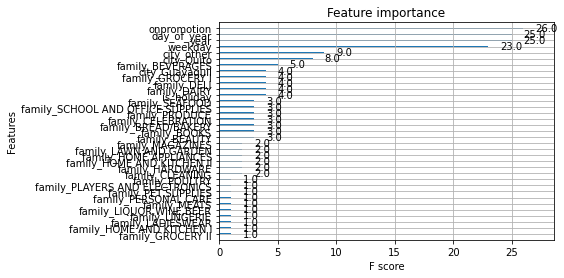

In [41]:
from xgboost import plot_importance

plot_importance(gs.best_estimator_)
plt.show()

In [42]:
# eval_predicted = gs.predict(X_eval)
# eval_predicted

In [43]:
# from sklearn.metrics import mean_squared_log_error

# def RMSLE(y_true: np.array, y_pred: np.array) -> np.float64:
#     return mean_squared_log_error(y_true, y_pred, squared=False)

In [44]:
# RMSLE(y_eval, abs(eval_predicted))

# Predict for Kaggle test set

In [45]:
test_predicted = gs.predict(df_test[columns])

In [46]:
dfs['sample_submission'].sales = test_predicted

In [47]:
dfs['sample_submission'].to_csv('submission.csv', index=False)

In [48]:
dfs['sample_submission'].head()

,id,sales
0,3000888,213.471283
1,3000889,213.471283
2,3000890,402.595032
3,3000891,2748.662598
4,3000892,92.936813


In [49]:
df_test.head()

,id,date,store_nbr,sales,onpromotion,weekday,year,month,day_of_year,day_from_global_start,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
3000888,3000888,2017-08-16,1,NaN,0,2,2017,8,256,1688,...,0,0,0,0,0,0,0,0,0,0
3000889,3000889,2017-08-16,1,NaN,0,2,2017,8,256,1688,...,0,0,0,0,0,0,0,0,0,0
3000890,3000890,2017-08-16,1,NaN,2,2,2017,8,256,1688,...,0,0,0,0,0,0,0,0,0,0
3000891,3000891,2017-08-16,1,NaN,20,2,2017,8,256,1688,...,0,0,0,0,0,0,0,0,0,0
3000892,3000892,2017-08-16,1,NaN,0,2,2017,8,256,1688,...,0,0,0,0,0,0,0,0,0,0


# Trash

In [50]:
# dfs['holidays_events'].transferred.value_counts()

In [51]:
# df_full['is_holiday'] = df_full.apply(lambda x : (x.date - datetime.datetime(df_full.iloc[0].date.year, 1, 1)).days + 1, axis=1)


In [52]:
# df_full.iloc[0].date.year

In [53]:
# dfs.keys()